# **Evaluation of the models**

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import utils

## **Model performance evaluation**

In [2]:
test_data = pd.read_csv("../../02_data/nn_baseline_test.csv", header=None)
test_data = np.array(test_data)

In [3]:
model = keras.models.load_model("../../04_nn_models/fed_noshare/")

2023-01-31 07:18:35.545837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 07:18:35.557501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 07:18:35.557682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 07:18:35.558452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
result = model.evaluate(test_data[:,:-1],
                  test_data[:,-1], batch_size=1000)

print("Test loss:\t%.4f"%result)

2023-01-31 07:18:36.162007: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 393192000 exceeds 10% of free system memory.
2023-01-31 07:18:36.292099: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 393192000 exceeds 10% of free system memory.


136/762 [====>.........................] - ETA: 0s - loss: 1.1069

2023-01-31 07:18:36.829108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


762/762 [==============================] - 1s 1ms/step - loss: 1.0155
Test loss:	1.0155


In [5]:
PARKING_ID_LIST = [i for i in range(1059, 1186+1)]
MIN_T = 14400
MAX_T = 50460
MEAN = 0.59
STD = 0.35302

MEAS_ROOT = "../../dockeroutput/"

In [6]:
nominals = pd.read_csv(MEAS_ROOT+"day_59/occupancies.csv")

MOST_PATH = "../../build_inputs//MoSTScenario/scenario/most.sumocfg"
PARKING_AREA_DEFINITIONS = "../../build_inputs/MoSTScenario/scenario/in/add/most.parking.add.xml"

parking_df = pd.read_xml(PARKING_AREA_DEFINITIONS)
parking_df = parking_df[parking_df["roadsideCapacity"]>0]
parking_df = parking_df.set_index(["id"])

perc_ = []
for i,r in nominals.iterrows():
    perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
nominals["percentage"] = perc_

In [7]:
PARKING_ID = 1140

In [8]:
id_list = PARKING_ID_LIST

test_t = np.arange(14400, 50400, 60)
test_t = utils.normalize(test_t, MIN_T, MAX_T)

id_encoding = utils.one_hot_encoder([PARKING_ID]*len(test_t), id_list)
#print(id_encoding.shape)

test_d = np.hstack([id_encoding, test_t.reshape(len(test_t), 1)])
#print(test_d.shape)

output = model.predict(test_d)
output = utils.de_standardize(output, MEAN, STD)

19/19 [==============================] - 0s 733us/step


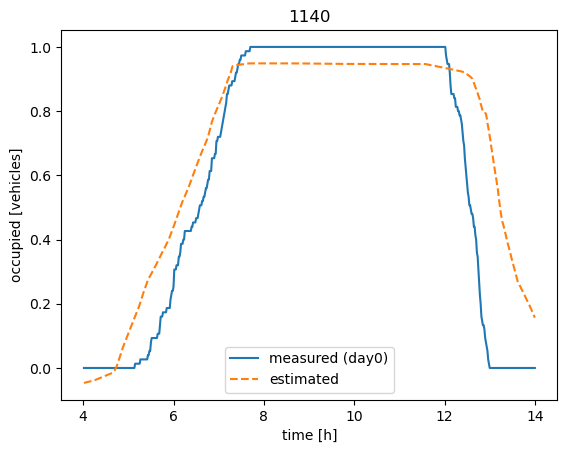

In [9]:
p_lot = nominals[nominals["ids"] == PARKING_ID]
p_lot_occup = p_lot.groupby("timestamp")["percentage"].mean()
plt.plot(p_lot_occup.index/(60*60), p_lot_occup, label="measured (day0)")
plt.plot(p_lot_occup.index/(60*60), output, "--", label="estimated")
plt.xlabel("time [h]")
plt.ylabel("occupied [vehicles]")
plt.legend()
plt.title(PARKING_ID)
plt.show()

## **Evaluation inference results**

In [10]:
with open("../../02_data/fed_accuracies.json", "r") as f:
    fed_accuracies = json.load(f)

In [15]:
pos_means, pos_stds = [], []
pos_max, pos_min = [], []
for i in range(55):
    pos_means.append(np.mean(fed_accuracies["position_accuracies"][i]))
    pos_stds.append(np.std(fed_accuracies["position_accuracies"][i]))
    pos_max.append(np.max(fed_accuracies["position_accuracies"][i]))
    pos_min.append(np.min(fed_accuracies["position_accuracies"][i]))
pos_means = np.array(pos_means)
pos_stds = np.array(pos_stds)

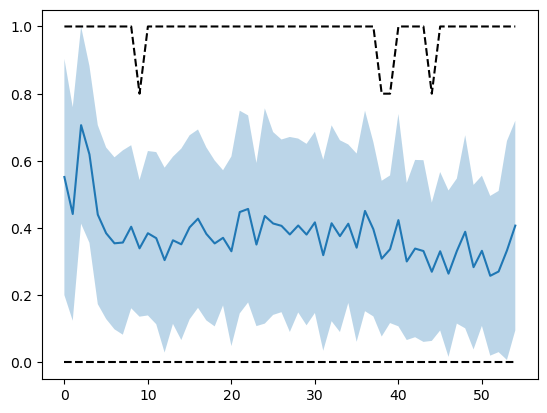

In [16]:
plt.plot(pos_means, label="mean accuracies")
plt.fill_between(x=np.arange(0, 55, 1),
                 y1=pos_means-pos_stds, y2=pos_means+pos_stds, label="std. accuracies",
                 alpha=0.3)
plt.plot(pos_max, "--", color="k", label="max")
plt.plot(pos_min, "--", color="k", label="min")

In [17]:
t_means, t_stds = [], []
t_max, t_min = [], []
for i in range(55):
    t_means.append(np.mean(fed_accuracies["time_accuracies"][i]))
    t_stds.append(np.std(fed_accuracies["time_accuracies"][i]))
    t_max.append(np.max(fed_accuracies["time_accuracies"][i]))
    t_min.append(np.min(fed_accuracies["time_accuracies"][i]))
t_means = np.array(t_means)
t_stds = np.array(t_stds)

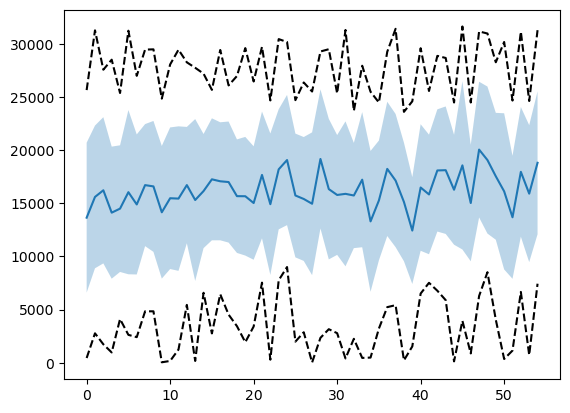

In [18]:
plt.plot(t_means, label="mean accuracies")
plt.fill_between(x=np.arange(0, 55, 1),
                 y1=t_means-t_stds, y2=t_means+t_stds, label="std. accuracies",
                 alpha=0.3)
plt.plot(t_max, "--", color="k", label="max")
plt.plot(t_min, "--", color="k", label="min")